# Analysis of WWW dataset

WWW dataset is identified as the most sparse graph in C&F paper. In this notebook, we will compute an empirical growth rate of edges w.r.t the number of nodes, and fit two different curves to this empirical growth.

In [1]:
import os
import pickle

import time
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csc_matrix, csr_matrix, dok_matrix
from scipy.optimize import curve_fit

%matplotlib inline

### Load WWW dataset with sparse matrices

In [2]:
n_e = 325729

def getWWWdataset(n_e = 325729, shuffle=True):    
    if shuffle:
        node_idx = np.arange(n_e)
        np.random.shuffle(node_idx)
        node_dic = {i:node_idx[i] for i in range(n_e)}
    else:
        node_dic = {i:i for i in range(n_e)}

    row_list = list()
    col_list = list()
    with open('../data/www/www.dat.txt', 'r') as f:
        for line in f.readlines():
            row, col = line.split()
            row = int(row.strip())
            col = int(col.strip())
            row_list.append(node_dic[row])
            col_list.append(node_dic[col])
                
    return row_list, col_list

## Compute growth rate of WWW dataset with varying size of nodes

In [3]:
if not os.path.exists('www_growth.pkl'):
    n_e = 325729
    n_link = defaultdict(list)
    n_samples = 10

    for si in range(n_samples):
        row_list, col_list = getWWWdataset()
        www_row = csr_matrix((np.ones(len(row_list)), (row_list, col_list)), shape=(n_e, n_e))
        www_col = csc_matrix((np.ones(len(row_list)), (row_list, col_list)), shape=(n_e, n_e))

        n_link[0].append(0)

        for i in range(1, n_e):
            # counting triples by expanding tensor
            cnt = 0
            cnt += www_row.getrow(i)[:,:i].nnz
            cnt += www_col.getcol(i)[:i-1,:].nnz 
            n_link[i].append(cnt + n_link[i-1][-1])
    
    pickle.dump(n_link, open('www_growth.pkl', 'wb'))
else:
    n_link = pickle.load(open('www_growth.pkl', 'rb'))
    
avg_cnt = [np.mean(n_link[i]) for i in range(n_e)]

### Fit the growth curve 

In [4]:
def func(x, a, b, c):
    return c*x**a + b

def poly2(x, a, b, c):
    return c*x**2 + b*x + a

popt, pcov = curve_fit(func, np.arange(n_e), avg_cnt)
fitted_t = func(np.arange(n_e), *popt)

popt2, pcov2 = curve_fit(poly2, np.arange(n_e), avg_cnt)
fitted_t2 = poly2(np.arange(n_e), *popt2)

### Plot the empirical and fitted growth curves

[100000, 150000, 100000, 350000]

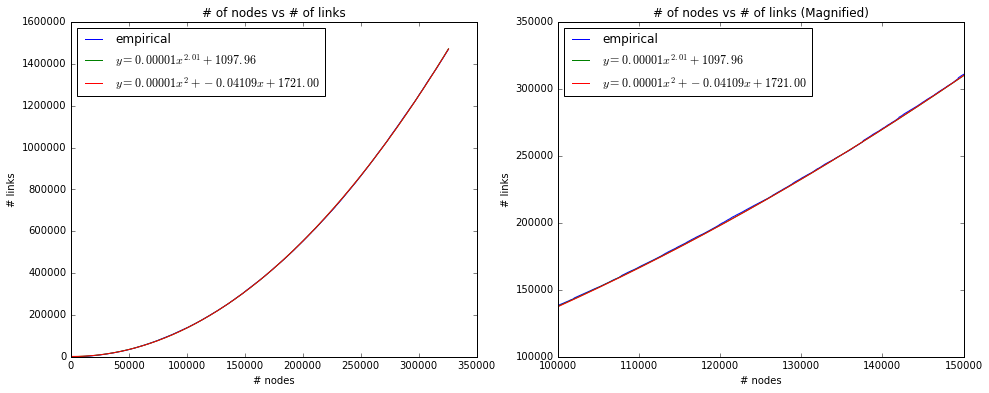

In [5]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(avg_cnt, label='empirical')
plt.plot(fitted_t, label='$y=%.5f x^{%.2f} + %.2f$' % (popt[2], popt[0], popt[1]))
plt.plot(fitted_t2, label='$y=%.5f x^2 + %.5f x + %.2f$' % (popt2[2], popt2[1], popt2[0]))

plt.legend(loc='upper left')
plt.title('# of nodes vs # of links')
plt.xlabel('# nodes')
plt.ylabel('# links')

plt.subplot(1,2,2)
plt.plot(avg_cnt, label='empirical')
plt.plot(fitted_t, label='$y=%.5f x^{%.2f} + %.2f$' % (popt[2], popt[0], popt[1]))
plt.plot(fitted_t2, label='$y=%.5f x^2 + %.5f x + %.2f$' % (popt2[2], popt2[1], popt2[0]))

plt.legend(loc='upper left')
plt.title('# of nodes vs # of links (Magnified)')
plt.xlabel('# nodes')
plt.ylabel('# links')
plt.axis([100000,150000,100000,350000])

[0, 325729, 0, 325729]

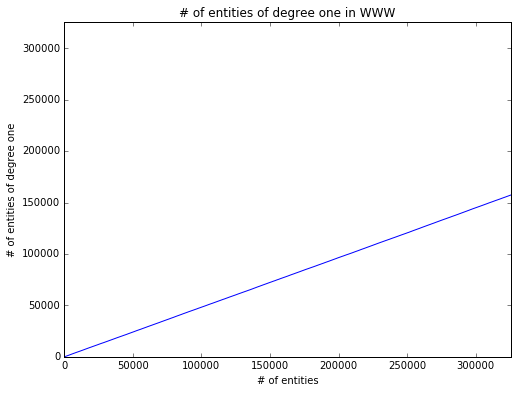

In [6]:
row_list, col_list = getWWWdataset()
www_row = csr_matrix((np.ones(len(row_list)), (row_list, col_list)), shape=(n_e, n_e))
www_col = csc_matrix((np.ones(len(row_list)), (row_list, col_list)), shape=(n_e, n_e))

entity_degree = (www_row.sum(1) + www_col.sum(0).T).tolist()

e_list = np.arange(n_e)
np.random.shuffle(e_list)
one_entity = [entity_degree[ei][0] == 1 for ei in e_list]
cumsum = np.cumsum(one_entity)        

plt.figure(figsize=(8,6))
plt.plot(cumsum) 
plt.xlabel('# of entities')
plt.ylabel('# of entities of degree one')
plt.title('# of entities of degree one in WWW')
plt.axis([0, n_e, 0, n_e])